In [175]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns

a = 0.25
b = 0.75

# matrix to be decomposed
A = np.array(
    [[a,  0, 0,  b],
     [0, -a, b,  0],
     [0,  b, a,  0],
     [b,  0, 0, -a]]
)

LCU = qml.pauli_decompose(A)
LCU_coeffs, LCU_ops = LCU.terms()

print(f"LCU decomposition:\n {LCU}")
print(f"Coefficients:\n {LCU_coeffs}")
print(f"Unitaries:\n {LCU_ops}")

LCU decomposition:
 0.25 * (I(0) @ Z(1)) + 0.75 * (X(0) @ X(1))
Coefficients:
 [0.25 0.75]
Unitaries:
 [I(0) @ Z(1), X(0) @ X(1)]


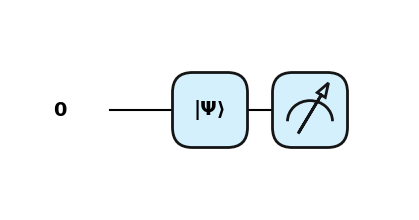

Target state:  [0.5       0.8660254]
Output state:  [0.5       0.8660254]


In [176]:
dev1 = qml.device("default.qubit", wires=1)

# normalized square roots of coefficients
alphas = (np.sqrt(LCU_coeffs) / np.linalg.norm(np.sqrt(LCU_coeffs)))


@qml.qnode(dev1)
def prep_circuit():
    qml.StatePrep(alphas, wires=0)
    return qml.state()

qml.draw_mpl(prep_circuit, style='pennylane')()
plt.show()

print("Target state: ", alphas)
print("Output state: ", np.real(prep_circuit()))

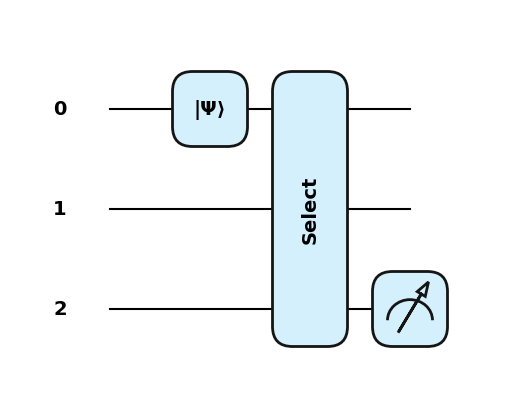

Expectation value for input |0>: 1.0
Expectation value for input |1>: -1.0


In [177]:
import matplotlib.pyplot as plt

dev2 = qml.device("default.qubit", wires=3)

# unitaries
ops = LCU_ops
# relabeling wires: 0 → 1, and 1 → 2
unitaries = [qml.map_wires(op, {0: 1, 1: 2}) for op in ops]


@qml.qnode(dev2)
def sel_circuit(qubit_value):
    qml.BasisState(qubit_value, wires=0)
    qml.Select(unitaries, control=0)
    return qml.expval(qml.PauliZ(2))

qml.draw_mpl(sel_circuit, style='pennylane')([0])
plt.show()

print('Expectation value for input |0>:', sel_circuit([0]))
print('Expectation value for input |1>:', sel_circuit([1]))

1.3660254037844388


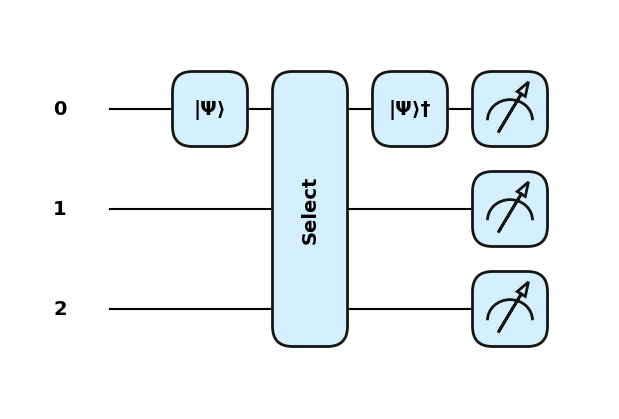

A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

Block-encoded A:

[[ 0.25  0.    0.    0.75 -0.43  0.    0.    0.43]
 [ 0.   -0.25  0.75  0.    0.    0.43  0.43  0.  ]
 [ 0.    0.75  0.25  0.    0.    0.43 -0.43  0.  ]
 [ 0.75  0.    0.   -0.25  0.43  0.    0.    0.43]
 [-0.43  0.    0.    0.43  0.75  0.    0.    0.25]
 [ 0.    0.43  0.43  0.    0.   -0.75  0.25  0.  ]
 [ 0.    0.43 -0.43  0.    0.    0.25  0.75  0.  ]
 [ 0.43  0.    0.    0.43  0.25  0.    0.   -0.75]]


In [178]:
scaling_factor = sum(abs(alphas))
print(scaling_factor)

@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()

qml.draw_mpl(lcu_circuit, style='pennylane')()
plt.show()

output_matrix = qml.matrix(lcu_circuit)()
print("A:\n", A, "\n")
print("Block-encoded A:\n")
print(np.real(np.round(output_matrix,2)))

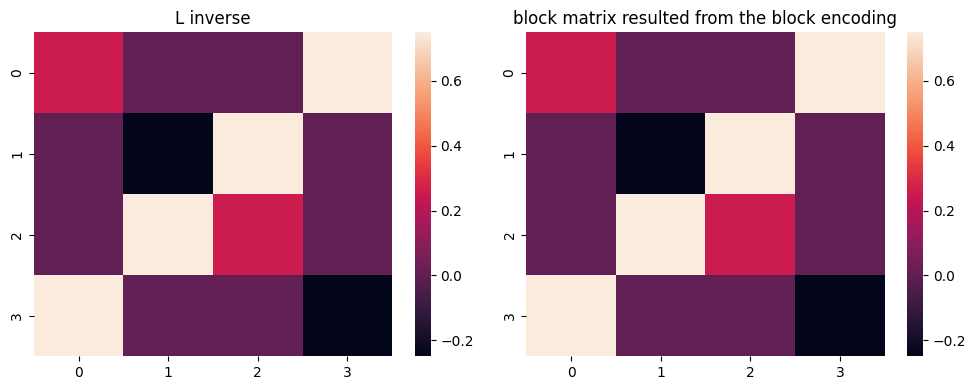

In [179]:
submatrix = output_matrix[:4, :4]

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(np.linalg.matrix_power(A, 1), ax=axes[0]) # vmin=0.01, vmax=0.05
axes[0].set_title("L inverse")
sns.heatmap(np.real(np.round(submatrix, 3)), ax=axes[1])
axes[1].set_title("block matrix resulted from the block encoding")
plt.tight_layout()
plt.show()

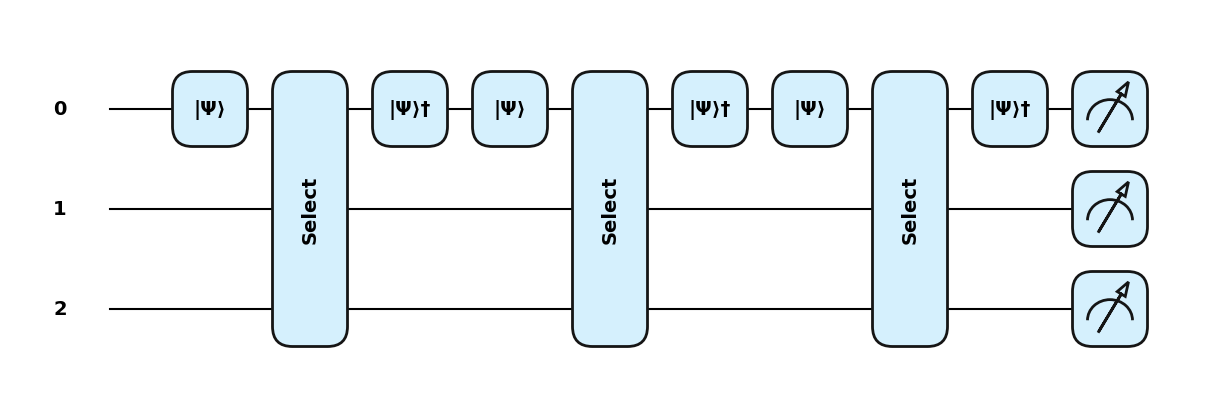

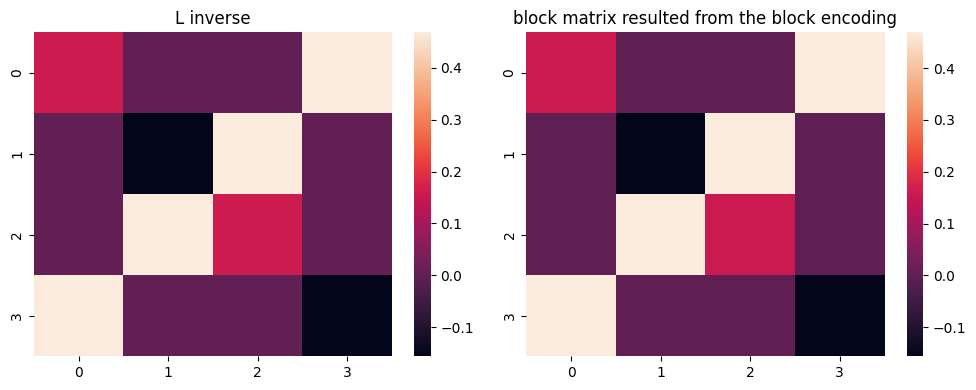

In [180]:
num_iter = 3
scaling_factor = sum(abs(alphas))

@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    for _ in range(num_iter):
        qml.StatePrep(alphas, wires=0)
        qml.Select(unitaries, control=0)
        qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()

qml.draw_mpl(lcu_circuit, style='pennylane')()
plt.show()

output_matrix = qml.matrix(lcu_circuit)()
submatrix = output_matrix[:4, :4]
factor = np.linalg.matrix_power(A, num_iter)[0,0]/submatrix[0,0]

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(np.linalg.matrix_power(A, num_iter), ax=axes[0]) # vmin=0.01, vmax=0.05
axes[0].set_title("L inverse")
sns.heatmap(np.real(np.round(submatrix*factor, 3)), ax=axes[1])
axes[1].set_title("block matrix resulted from the block encoding")
plt.tight_layout()
plt.show()

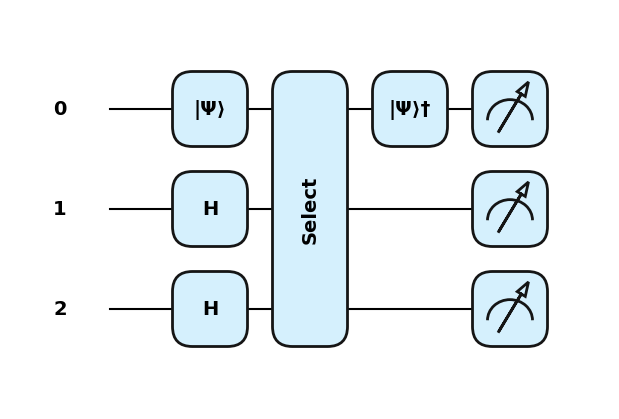

A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

projector : 
      0    1    2    3    4    5    6    7
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Projected density matrix (qubit 0 in |0⟩) :
      0    1    2    3    4    5    6    7
0  0.4  0.2  0.4  0.2  0.0  0.0  0.0  0.0
1  0.2  0.1  0.2  0.1  0.0  0.0  0.0  0.0
2  0.4  0.2  0.4  0.2  0.0  0.0  0.0  0.0
3  0.2  0.1  0.2  0.1  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [212]:
num_iter = 1
scaling_factor = sum(abs(alphas))

dev2 = qml.device("default.qubit", wires=3)

@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    qml.Hadamard(1)
    qml.Hadamard(2)
    
    for _ in range(num_iter):
        qml.StatePrep(alphas, wires=0)
        qml.Select(unitaries, control=0)
        qml.adjoint(qml.StatePrep(alphas, wires=0))

    return qml.density_matrix(wires=range(3))

qml.draw_mpl(lcu_circuit, style='pennylane')()
plt.show()

print("A:\n", A, "\n")

dm = lcu_circuit()

# post-precossing to project the density matrix onto |0> in the first qubit
P0 = np.array([[1, 0], [0, 0]]) 
I = np.eye(2)
projector = np.kron(P0, np.kron(I, I))
print("projector : \n", pd.DataFrame(projector))

projected_rho = projector @ dm @ projector.T
projected_rho /= np.trace(projected_rho)  # Normalize

print("Projected density matrix (qubit 0 in |0⟩) :\n",pd.DataFrame(np.real(projected_rho)))

In [64]:
init_vec = np.ones(4)/np.sqrt(4)
print(init_vec)
print(A @ init_vector)

# # visualization of the vector with heatmap
# vector = A @ init_vector
# # matrix = vector.reshape(1, -1)  # row-wise
# matrix = vector.reshape(-1, 1)  # column-wise
# sns.heatmap(matrix, annot=True)
# plt.show()

[0.5 0.5 0.5 0.5]
[0.5  0.25 0.5  0.25]


In [65]:
init_vec_pd = np.pad(init_vec, (0,4), 'constant')
print(init_vec_pd)
print(np.real(output_matrix @ init_vec_pd)[:4])

# # visualization of the vector with heatmap
# vector = np.real(output_matrix @ init_vec_pd)[:4]
# # matrix = vector.reshape(1, -1)  # row-wise
# matrix = vector.reshape(-1, 1)  # column-wise
# sns.heatmap(matrix, annot=True)
# plt.show()

[0.5 0.5 0.5 0.5 0.  0.  0.  0. ]
[0.5  0.25 0.5  0.25]


In [171]:
import pennylane as qml
import numpy as np

# Define matrix A and decompose
A = np.array([[0.1, 0.2], [0.3, 0.4]])
decomp = qml.pauli_decompose(A)
terms = decomp.terms()
coeffs = [t[0] for t in terms]
ops = [t[1] for t in terms]
len(alphas) = len(coeffs)

# Device with no shots (statevector)
dev = qml.device("default.qubit", wires=1 + len(alphas) + 1)

@qml.qnode(dev)
def block_encoding():
    ancilla = list(range(len(alphas)))
    target = len(alphas)
    readout = len(alphas) + 1

    for wire in ancilla:
        qml.Hadamard(wires=wire)

    for i, op in enumerate(ops):
        qml.ctrl(op, control=ancilla[i])(wires=target)

    for wire in reversed(ancilla):
        qml.Hadamard(wires=wire)

    qml.CNOT(wires=[target, readout])
    return qml.state()

# Get full statevector
state = block_encoding()

# Build projector onto ancilla = |0...0>
P = np.array([[1, 0], [0, 0]])
projector = P
for _ in range(len(alphas) - 1):
    projector = np.kron(projector, P)

# Identity for remaining wires
I = np.eye(2 ** (dev.num_wires - len(alphas)))
full_projector = np.kron(projector, I)

# Apply projector and normalize
projected_state = full_projector @ state
normalized_state = projected_state / np.linalg.norm(projected_state)

print("Exact post-selected state:")
print(normalized_state)

ValueError: The matrix is not Hermitian

In [ ]:
coeffs = np.array([1/2, 1/2])
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))

proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires="ancilla")

    # SEL
    qml.Select(proj_unitaries, control="ancilla")

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires="ancilla"))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit, wire_order=["ancilla", 0])()
print("Block-encoded projector:\n")
print(np.real(np.round(output_matrix,2)))

In [ ]:
coeffs = np.array([1/2, 1/2])
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))

proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires="ancilla")

    # SEL
    qml.Select(proj_unitaries, control="ancilla")

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires="ancilla"))

    
    return qml.state()


output_matrix = qml.matrix(lcu_circuit, wire_order=["ancilla", 0])()
print("Block-encoded projector:\n")
print(np.real(np.round(output_matrix,2)))